In [ ]:
import argparse
import os
import torch
import sys

#from exp.exp_classification import Exp_Classification
import random
import numpy as np
from torch import optim
from torch.utils.data import DataLoader

import time
import torch.nn as nn

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import sys

from models import (
    Autoformer,
    Crossformer,
    FEDformer,
    Informer,
    iTransformer,
    MTST,
    Nonstationary_Transformer,
    PatchTST,
    Reformer,
    Transformer,
    Medformer,
    ProtoPTST
)
gpu_n=3
device=f"cuda:{gpu_n}"
dataset_name="mitecg"  # freqshape  seqcomb_single, mitecg, 'seqcomb_single_better'
SEQ_LEN=360 # 500
CHANNEL=1
DATASET_PATH="/home/hbs/TS/XTS/TimeX/datasets/MITECG" # 
CLASS_NUMBER=2
SPLIT=1  # 101
proto_len=30
PROTO_NUM=4

BATCH_SIZE=128

%load_ext autoreload 
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

#sys.path.append("/home/hbs/TS/my_p/shapeX/scr/ShapeX")
#from get_data import *

#train, val, test,gt_exps= get_saliency_data(dataset_name,device,SPLIT)

In [12]:
#for i in range(3):
    #print(test[i].shape)

In [13]:
#print(gt_exps.shape)

In [14]:

    #print("Targets:", targets)

In [15]:
"""
args={ "data":dataset_name,
      "flag":"train",
      "task_name":"classification",
      "embed":"timeF",
      "batch_size":32,
      'freq':"h",
      'root_path':"/home/hbs/TS/XTS/TimeX/datasets/SeqCombSingle",
      'num_workers':1,
      "seq_len":96}
"""
# Updated configuration based on the command-line arguments
config = {
    "task_name": "classification",  # Task name: classification
    "is_training": 1,  # Training status
    "model_id": dataset_name,  # Model ID
    "model": "ProtoPTST",  # Model: Transformer  PatchTST ProtoPTST
    
    # Data settings
    "data": dataset_name,  # Dataset: APAVA
    "root_path": "/home/hbs/TS/XTS/TimeX/datasets/SeqCombSingle",  # Root path of the dataset
    
    # Forecasting task settings (not used in this specific task)
    "seq_len": 96,  
    "label_len": 48,  
    "pred_len": 96,  
    "features": "S",
    "seasonal_patterns": "Monthly",
    "inverse": False,
    
    # Imputation and anomaly detection task settings (not used)
    "mask_rate": 0.25,  
    "anomaly_ratio": 0.25,
    
    # Model settings for classification
    "e_layers": 6,  # Number of encoder layers
    "d_model": 128,  # Model dimension
    "d_ff": 256,  # Feedforward network dimension
    "enc_in": 7,  # You might want to adjust these values
    "dec_in": 7,  
    "c_out": 7,  
    "n_heads": 8,  
    "top_k": 5,  
    "num_kernels": 6,
    "moving_avg": 25,
    "factor": 1,
    "distil": True,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": True,
    "no_inter_attn": False,
    "chunk_size": 16,
    "patch_len": 4, # 16
    "stride": 1,    # 8
    "sampling_rate": 256,
    "patch_len_list": [2, 4, 8],
    "single_channel": False,
    "augmentations": "flip,shuffle,jitter,mask,drop",
    
    # Optimization settings
    "batch_size": BATCH_SIZE,  # Batch size
    "train_epochs": 100,  # Number of training epochs
    "learning_rate": 0.0001,  # Learning rate
    "itr": 5,  # Number of iterations
    "patience": 10,  # Early stopping patience
    "des": "Exp",  # Experiment description
    "loss": "MSE",  
    "lradj": "type1",
    "use_amp": False,
    "swa": False,
    "d_layers":1,
    
    # GPU settings
    "use_gpu": True,  # Use GPU
    "gpu": gpu_n,  # Specify the GPU ID
    "use_multi_gpu": False,
    "devices": f"{gpu_n}",
    "device": f"cuda:{gpu_n}",
    
    # De-stationary projector parameters
    "p_hidden_dims": [128, 128],  
    "p_hidden_layers": 2,
    'freq':"h",
    'num_workers':1,
    "seq_len":SEQ_LEN,
    
    # building model args:
    "pred_len": 0,
    "enc_in": CHANNEL,
    "num_class": CLASS_NUMBER,
    
    
    # protoptst args
    "num_prototypes": PROTO_NUM,
    #"prototype_shape": [1,197,1],
    "prototype_len": proto_len

    
    
}
# Example: Accessing an updated parameter

args = argparse.Namespace(**config)
print(args.data)
print(config['model_id'])  # Output: APAVA-Indep


model = Transformer.Model(args).float()
      # pass args to model

mitecg
mitecg


In [ ]:
def interpolate_tensor(input_tensor,new_T=480,dim_to_change=0):

    # 需要先交换维度，将 T 维度放在最后，方便使用 interpolate
    last_dim=len(input_tensor.shape)-1
    input_tensor = input_tensor.transpose(dim_to_change,last_dim)  # 现在形状变为 (batch_size, D, T)

    # 使用 interpolate 函数
    output_tensor = torch.nn.functional.interpolate(input_tensor, size=new_T, mode='linear', align_corners=True)
    print(output_tensor.shape)

    # 再次交换维度，将 D 维度放回到最后
    output_tensor = output_tensor.transpose(dim_to_change,last_dim)  # 现在形状变为 (batch_size, new_T, D)

    return output_tensor


class Get_torch_dataset(torch.utils.data.Dataset):
    def __init__(self, X, times, y, augment_negative = None,T_first=False,interpolate=True):
        
        if T_first: # ECG dataset
            X = X.transpose(1,0) # Shape: (T, N, d) ->(N, T, d) 
        
        self.X = X
        self.y = y # Shape: (N,)
        
        if interpolate:
            self.X = interpolate_tensor(self.X,new_T=500,dim_to_change=1)
        # print('X', self.X.shape)
        # print('times', self.times.shape)
        # print('y', self.y.shape)
        # exit()
        self.max_seq_len=self.X.shape[1]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx,one_hot=False):
        x = self.X[idx,:,:]
        #T = self.times[:,idx]
        y = self.y[idx]
        
        if one_hot:
            ONE_HOT=torch.tensor([[1,0],[0,1]]).to(device)
            y_one_hot=ONE_HOT[y]
        return x, y , torch.ones((x.shape[0],x.shape[1],128))
    
    
class Get_ECG_dataset(torch.utils.data.Dataset):
    def __init__(self, X, times, y, augment_negative = None):
        self.X = X.transpose(1,0) # Shape: (T, N, d) ->(N, T, d) 
        #self.times = times # Shape: (T, N)
        self.y = y # Shape: (N,)
        # print('X', self.X.shape)
        # print('times', self.times.shape)
        # print('y', self.y.shape)
        # exit()
        self.max_seq_len=self.X.shape[1]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx,one_hot=False):
        x = self.X[idx,:,:]
        #T = self.times[:,idx]
        y = self.y[idx]
        
        if one_hot:
            ONE_HOT=torch.tensor([[1,0],[0,1]]).to(device)
            y_one_hot=ONE_HOT[y]
        return x, y , torch.ones((x.shape[0],x.shape[1],128))

In [17]:


#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer/checkpoints/classification/APAVA-Indep/Transformer/classification_APAVA-Indep_Transformer_APAVA_ftM_sl96_ll48_pl96_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))

#data_set, data_loader = data_provider(args, flag="TEST")







In [20]:
#  ---------------- get ECG data

sys.path.append("/home/hbs/TS/XTS/TimeX")
from txai.synth_data.simple_spike import SpikeTrainDataset
from txai.utils.data.preprocess import process_MITECG, process_Boiler
from txai.utils.data import process_Synth



#D = process_Synth(split_no = 1, device = device, base_path = DATASET_PATH)
D = process_MITECG(split_no = 1, device = device, hard_split = True, need_binarize = True, exclude_pac_pvc = True, base_path = DATASET_PATH)

train, val, test, gt_exps = D

X, times, y = test.X, test.time, test.y 

print(X.shape)




mask = (y == 1).clone().cpu() ##### !!! orignal setting

#mask = (y == 1) | (y == 0) ### choose two class
mask=mask.clone().cpu()
print("###### main: mask.shape: ",mask.shape)

# Detect when we fail to observe a wave:
detection_failure = (gt_exps.squeeze().sum(0) > 0) 
mask = mask & detection_failure ##### !!! orignal setting
X = X[:,mask,:]
times = times[:,mask]
gt_exps = gt_exps[:,mask,:]
y = y[mask]


#output,attens=model.classification(x,x_mark_enc)

# for  ECG dataset
train_dataset=Get_ECG_dataset(train.X,train.time,train.y)
val_dataset=Get_ECG_dataset(val.X,val.time,val.y)
test_dataset=Get_ECG_dataset(X,times,y)

data_dict={ # 
    "TEST":test_dataset,
    "VAL":val_dataset,
    "TRAIN":train_dataset
}

print(X.shape)

Num after 0 tensor(15008)
Num after 1 tensor(3041)
Num after 0 tensor(15002)
Num after 1 tensor(3066)
torch.Size([360, 18068, 1])
###### main: mask.shape:  torch.Size([18068])
torch.Size([360, 3007, 1])


In [19]:
# for s_n_2 dataset


train_dataset=Get_torch_dataset(train[0],train[1],train[2])
#val_dataset=Get_torch_dataset(val[0],val[1],val[2],None,True)
val_dataset=Get_torch_dataset(test[0][:,950:1050,:],test[1][:,950:1050],test[2][950:1050],None,True) # freqshape 274
test_dataset=Get_torch_dataset(test[0],test[1],test[2],None,True)


data_dict={ # 
    "TEST":test_dataset,
    "VAL":val_dataset,
    "TRAIN":train_dataset
}



AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# for  seqcomb_single_better and freshape
train_dataset=Get_torch_dataset(train[0],train[1],train[2])
val_dataset=Get_torch_dataset(val[0],val[1],val[2],None,True)
test_dataset=Get_torch_dataset(test[0],test[1],test[2],None,True)

data_dict={ # 
    "TEST":test_dataset,
    "VAL":val_dataset,
    "TRAIN":train_dataset
}


torch.Size([5000, 1, 500])
torch.Size([100, 1, 500])
torch.Size([1000, 1, 500])


AttributeError: 'tuple' object has no attribute 'transpose'

In [ ]:
unique, counts = np.unique(test[2][950:1050].to('cpu').numpy(), return_counts=True)
print(f"Labels distribution: {dict(zip(unique, counts))}")

Labels distribution: {0: 50, 1: 50}


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(
                f"Metric score decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n"
            )
        torch.save(model.state_dict(), path + "/" + "checkpoint.pth")
        self.val_loss_min = val_loss
class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.model_dict = {
            "Autoformer": Autoformer,
            "Crossformer": Crossformer,
            "FEDformer": FEDformer,
            "Informer": Informer,
            "iTransformer": iTransformer,
            "MTST": MTST,
            "Nonstationary_Transformer": Nonstationary_Transformer,
            "PatchTST": PatchTST,
            "Reformer": Reformer,
            "Transformer": Transformer,
            "Medformer": Medformer,
            "ProtoPTST":ProtoPTST
        }
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = (
                str(self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            )
            device = torch.device("cuda:{}".format(self.args.gpu))
            print("Use GPU: cuda:{}".format(self.args.gpu))
        else:
            device = torch.device("cpu")
            print("Use CPU")
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass

class Exp_Classification(Exp_Basic):
    def __init__(self, args, data_dict):
        self.data_dict = data_dict
        super().__init__(args)
        

        self.swa_model = optim.swa_utils.AveragedModel(self.model)
        self.swa = args.swa
       
        

    def _build_model(self):
        # model input depends on data
        # train_data, train_loader = self._get_data(flag='TRAIN')
        test_data, test_loader = self._get_data(self.data_dict,flag="TEST")
        self.args.seq_len = test_data.max_seq_len  # redefine seq_len
        self.args.pred_len = 0
        # self.args.enc_in = train_data.feature_df.shape[1]
        # self.args.num_class = len(train_data.class_names)
        self.args.enc_in = test_data.X.shape[2]  # redefine enc_in
        self.args.num_class = len(np.unique(test_data.y.cpu()))
        # model init
        model = (
            self.model_dict[self.args.model].Model(self.args).float()
        )  # pass args to model
        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
            
        print("self.args.seq_len", self.args.seq_len)
        return model

    def _get_data(self, data_dict,flag):
        random.seed(self.args.seed)
        data_set=data_dict[flag] 
        data_loader =  DataLoader(data_set, batch_size=self.args.batch_size, shuffle=True)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.CrossEntropyLoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        preds = []
        trues = []
        if self.swa:
            self.swa_model.eval()
        else:
            self.model.eval()
        with torch.no_grad():
            for i, (batch_x, label, padding_mask) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                padding_mask = padding_mask.float().to(self.device)
                label = label.to(self.device)

                if self.swa:
                    outputs = self.swa_model(batch_x, padding_mask, None, None)
                else:
                    outputs , place_holder,_= self.model(batch_x, padding_mask, None, None)

                pred = outputs.detach().cpu()
                loss = criterion(pred, label.cpu())
                total_loss.append(loss)

                preds.append(outputs.detach())
                trues.append(label)

        total_loss = np.average(total_loss)

        preds = torch.cat(preds, 0)
        trues = torch.cat(trues, 0)
        probs = torch.nn.functional.softmax(
            preds
        )  # (total_samples, num_classes) est. prob. for each class and sample
        trues_onehot = (
            torch.nn.functional.one_hot(
                trues.reshape(
                    -1,
                ).to(torch.long),
                num_classes=self.args.num_class,
            )
            .float()
            .cpu()
            .numpy()
        )
        # print(trues_onehot.shape)
        predictions = (
            torch.argmax(probs, dim=1).cpu().numpy()
        )  # (total_samples,) int class index for each sample
        probs = probs.cpu().numpy()
        trues = trues.flatten().cpu().numpy()
        # accuracy = cal_accuracy(predictions, trues)
        metrics_dict = {
            "Accuracy": accuracy_score(trues, predictions),
            "Precision": precision_score(trues, predictions, average="macro"),
            "Recall": recall_score(trues, predictions, average="macro"),
            "F1": f1_score(trues, predictions, average="macro"),
            "AUROC": roc_auc_score(trues_onehot, probs, multi_class="ovr"),
            "AUPRC": average_precision_score(trues_onehot, probs, average="macro"),
        }

        if self.swa:
            self.swa_model.train()
        else:
            self.model.train()
        return total_loss, metrics_dict

    def train(self, setting):
        train_data, train_loader = self._get_data(self.data_dict,flag="TRAIN")
        vali_data, vali_loader = self._get_data(self.data_dict,flag="VAL")
        test_data, test_loader = self._get_data(self.data_dict,flag="TEST")
        
        print(train_data.X.shape)
        print(train_data.y.shape)
        print(vali_data.X.shape)
        print(vali_data.y.shape)
        print(test_data.X.shape)
        print(test_data.y.shape)

        path = (
            "./checkpoints/"
            + self.args.task_name
            + "/"
            + self.args.model_id
            + "/"
            + self.args.model
            + "/"
            + setting
            + "/"
        )
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(
            patience=self.args.patience, verbose=True, delta=1e-5
        )

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()

            for i, (batch_x, label, padding_mask) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()

                batch_x = batch_x.float().to(self.device)
                padding_mask = padding_mask.float().to(self.device)
                label = label.to(self.device)
                
                #print(f"batch_x: {batch_x.shape}, label: {label.shape}, padding_mask: {padding_mask.shape}")
                outputs, place_holder_1, prototype= self.model(batch_x, padding_mask, None, None)
                #print("!!!!!",outputs,"@",label)
                
                prototype_loss =  self.model.seg_prototype_loss ( place_holder_1,batch_x,prototype)
                
                global place_holder 
                place_holder = place_holder_1
                
                
                loss =  criterion(outputs, label)+ prototype_loss  
                
            
                
                train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("#"*10,"prototype_loss",prototype_loss,"loss",criterion(outputs, label),"#"*10)
                    
                    print(
                        "\titers: {0}, epoch: {1} | loss: {2:.7f}".format(
                            i + 1, epoch + 1, loss.item()
                        )
                    )
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * (
                        (self.args.train_epochs - epoch) * train_steps - i
                    )
                    print(
                        "\tspeed: {:.4f}s/iter; left time: {:.4f}s".format(
                            speed, left_time
                        )
                    )
                    iter_count = 0
                    time_now = time.time()

                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
                model_optim.step()

            self.swa_model.update_parameters(self.model)

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss, val_metrics_dict = self.vali(vali_data, vali_loader, criterion)
            test_loss, test_metrics_dict = self.vali(test_data, test_loader, criterion)

            print(
                f"Epoch: {epoch + 1}, Steps: {train_steps}, | Train Loss: {train_loss:.5f}\n"
                f"Validation results --- Loss: {vali_loss:.5f}, "
                f"Accuracy: {val_metrics_dict['Accuracy']:.5f}, "
                f"Precision: {val_metrics_dict['Precision']:.5f}, "
                f"Recall: {val_metrics_dict['Recall']:.5f}, "
                f"F1: {val_metrics_dict['F1']:.5f}, "
                f"AUROC: {val_metrics_dict['AUROC']:.5f}, "
                f"AUPRC: {val_metrics_dict['AUPRC']:.5f}\n"
                f"Test results --- Loss: {test_loss:.5f}, "
                f"Accuracy: {test_metrics_dict['Accuracy']:.5f}, "
                f"Precision: {test_metrics_dict['Precision']:.5f}, "
                f"Recall: {test_metrics_dict['Recall']:.5f} "
                f"F1: {test_metrics_dict['F1']:.5f}, "
                f"AUROC: {test_metrics_dict['AUROC']:.5f}, "
                f"AUPRC: {test_metrics_dict['AUPRC']:.5f}\n"
            )
            early_stopping(
                -val_metrics_dict["F1"],
                self.swa_model if self.swa else self.model,
                path,
            )
            if early_stopping.early_stop:
                print("Early stopping")
                break
            """if (epoch + 1) % 5 == 0:
                adjust_learning_rate(model_optim, epoch + 1, self.args)"""

        best_model_path = path + "checkpoint.pth"
        if self.swa:
            self.swa_model.load_state_dict(torch.load(best_model_path),map_location=self.device)
        else:
            self.model.load_state_dict(torch.load(best_model_path),map_location=self.device)

        return self.model

    def test(self, setting, test=0):
        vali_data, vali_loader = self._get_data(self.data_dict,flag="VAL")
        test_data, test_loader = self._get_data(self.data_dict,flag="TEST")
        if test:
            print("loading model")
            path = (
                "./checkpoints/"
                + self.args.task_name
                + "/"
                + self.args.model_id
                + "/"
                + self.args.model
                + "/"
                + setting
                + "/"
            )
            model_path = path + "checkpoint.pth"
            if not os.path.exists(model_path):
                raise Exception("No model found at %s" % model_path)
            if self.swa:
                self.swa_model.load_state_dict(torch.load(model_path))
            else:
                self.model.load_state_dict(torch.load(model_path))

        criterion = self._select_criterion()
        vali_loss, val_metrics_dict = self.vali(vali_data, vali_loader, criterion)
        test_loss, test_metrics_dict = self.vali(test_data, test_loader, criterion)

        # result save
        folder_path = (
            "./results/"
            + self.args.task_name
            + "/"
            + self.args.model_id
            + "/"
            + self.args.model
            + "/"
        )
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        print(
            f"Validation results --- Loss: {vali_loss:.5f}, "
            f"Accuracy: {val_metrics_dict['Accuracy']:.5f}, "
            f"Precision: {val_metrics_dict['Precision']:.5f}, "
            f"Recall: {val_metrics_dict['Recall']:.5f}, "
            f"F1: {val_metrics_dict['F1']:.5f}, "
            f"AUROC: {val_metrics_dict['AUROC']:.5f}, "
            f"AUPRC: {val_metrics_dict['AUPRC']:.5f}\n"
            f"Test results --- Loss: {test_loss:.5f}, "
            f"Accuracy: {test_metrics_dict['Accuracy']:.5f}, "
            f"Precision: {test_metrics_dict['Precision']:.5f}, "
            f"Recall: {test_metrics_dict['Recall']:.5f}, "
            f"F1: {test_metrics_dict['F1']:.5f}, "
            f"AUROC: {test_metrics_dict['AUROC']:.5f}, "
            f"AUPRC: {test_metrics_dict['AUPRC']:.5f}\n"
        )
        file_name = "result_classification.txt"
        f = open(os.path.join(folder_path, file_name), "a")
        f.write(setting + "  \n")
        f.write(
            f"Validation results --- Loss: {vali_loss:.5f}, "
            f"Accuracy: {val_metrics_dict['Accuracy']:.5f}, "
            f"Precision: {val_metrics_dict['Precision']:.5f}, "
            f"Recall: {val_metrics_dict['Recall']:.5f}, "
            f"F1: {val_metrics_dict['F1']:.5f}, "
            f"AUROC: {val_metrics_dict['AUROC']:.5f}, "
            f"AUPRC: {val_metrics_dict['AUPRC']:.5f}\n"
            f"Test results --- Loss: {test_loss:.5f}, "
            f"Accuracy: {test_metrics_dict['Accuracy']:.5f}, "
            f"Precision: {test_metrics_dict['Precision']:.5f}, "
            f"Recall: {test_metrics_dict['Recall']:.5f}, "
            f"F1: {test_metrics_dict['F1']:.5f}, "
            f"AUROC: {test_metrics_dict['AUROC']:.5f}, "
            f"AUPRC: {test_metrics_dict['AUPRC']:.5f}\n"
        )
        f.write("\n")
        f.write("\n")
        f.close()
        return

In [ ]:
# training classification model:

%load_ext autoreload 
%autoreload 

for ii in range(args.itr):
    seed = 41 + ii
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # comment out the following lines if you are using dilated convolutions, e.g., TCN
    # otherwise it will slow down the training extremely
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


    # setting record of experiments
    args.seed = seed
    setting = "{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_seed{}".format(
        args.task_name,
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des,
        args.seed,
    )

    exp = Exp_Classification(args,data_dict)  # set experiments
    print(
        ">>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>".format(setting)
    )
    exp.train(setting)

    print(
        ">>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<".format(setting)
    )
    exp.test(setting)
    torch.cuda.empty_cache()

NameError: name 'args' is not defined

In [ ]:
print(batch[1].shape)

torch.Size([4])


In [21]:
dataloader=DataLoader(test_dataset, batch_size=20, shuffle=False)
batch = next(iter(dataloader))

%load_ext autoreload 
%autoreload 
model = ProtoPTST.Model(args).float().to(device)
                                                                                                                        
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer_1/checkpoints/classification/freqshape/ProtoPTST/classification_freqshape_ProtoPTST_freqshape_ftS_sl1400_ll48_pl0_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer_1/checkpoints/classification/seqcomb_single_better/ProtoPTST/classification_seqcomb_single_better_ProtoPTST_seqcomb_single_better_ftS_sl200_ll48_pl0_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer_1/checkpoints/classification/seqcomb_single/ProtoPTST/classification_seqcomb_single_ProtoPTST_seqcomb_single_ftS_sl200_ll48_pl0_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))
model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer_1/checkpoints/classification/mitecg/ProtoPTST/classification_mitecg_ProtoPTST_mitecg_ftS_sl360_ll48_pl0_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/Medformer_1/checkpoints/classification/freqshape/ProtoPTST/classification_freqshape_ProtoPTST_freqshape_ftS_sl500_ll48_pl0_dm128_nh8_el6_dl1_df256_fc1_ebtimeF_dtTrue_Exp_seed41/checkpoint.pth"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

In [ ]:
dataloader=DataLoader(test_dataset, batch_size=20, shuffle=False)
batch = next(iter(dataloader))

%load_ext autoreload 
%autoreload 
model = ProtoPTST.Model(args).float().to(device)
                    
                    # 计算第 500 个元素在哪个批次和批次中的位置
target_index = 310  # 第  个元素对应索引  ！！2245
batch_size = 20
batch_index = target_index // batch_size  # 所在批次的索引
element_index = target_index % batch_size  # 批次内的索引

# 遍历批次直到找到包含第 500 个元素的批次
for i, batch in enumerate(dataloader):
    if i == batch_index:
        element_500 = batch
        #print(element_500)
        break
    
batch=element_500

out,actions,prototype =model(batch[0],0,0,0)

out,actions,prototype =model(batch[0],0,0,0)

choice=2
x_show=batch[0][choice].reshape(-1).cpu()     


%matplotlib inline
#print(place_holder.shape)
for choice in [4]:
    
    x_show=batch[0][choice].reshape(-1).cpu()

    plt.figure(figsize=(15, 5))
    plt.plot(x_show.cpu().numpy(), color='black',label="Input TS",linewidth=5)
    plt.title(f" Dataset: {dataset_name}: class{batch[1][choice]},  Prototype_num: {PROTO_NUM},  Prototype_len: {proto_len}",fontsize=20)
    for i in range(PROTO_NUM):
        line=actions[choice,:,i].reshape(-1).cpu().detach().numpy()
        

        
        # 设置画布大小为 10 x 5 英寸

        plt.plot(line,label=f"Activations_{i}",linewidth=1)

    plt.legend()

    plt.show()                                                                      


In [22]:
# 计算第 500 个元素在哪个批次和批次中的位置
target_index = 310  # 第  个元素对应索引  ！！2245
batch_size = 20
batch_index = target_index // batch_size  # 所在批次的索引
element_index = target_index % batch_size  # 批次内的索引

# 遍历批次直到找到包含第 500 个元素的批次
for i, batch in enumerate(dataloader):
    if i == batch_index:
        element_500 = batch
        #print(element_500)
        break
    
batch=element_500

out,actions,prototype =model(batch[0],0,0,0)



In [23]:
out,actions,prototype =model(batch[0],0,0,0)

choice=2
x_show=batch[0][choice].reshape(-1).cpu()

In [ ]:
print(batch[0].shape)

torch.Size([4, 360, 1])


In [ ]:
print(actions.shape)

torch.Size([4, 199, 2])


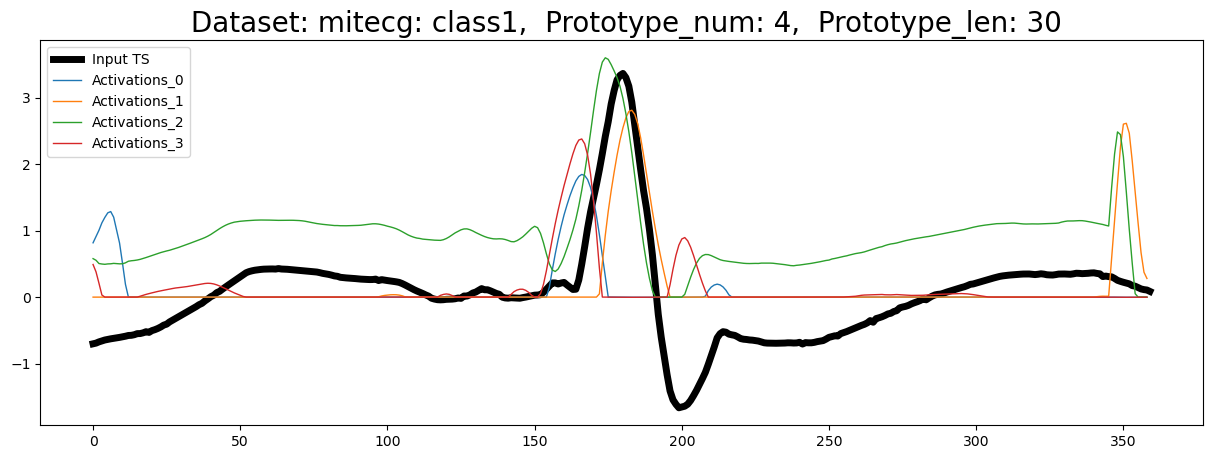

In [ ]:
%matplotlib inline
#print(place_holder.shape)
for choice in [4]:
    
    x_show=batch[0][choice].reshape(-1).cpu()

    plt.figure(figsize=(15, 5))
    plt.plot(x_show.cpu().numpy(), color='black',label="Input TS",linewidth=5)
    plt.title(f" Dataset: {dataset_name}: class{batch[1][choice]},  Prototype_num: {PROTO_NUM},  Prototype_len: {proto_len}",fontsize=20)
    for i in range(PROTO_NUM):
        line=actions[choice,:,i].reshape(-1).cpu().detach().numpy()
        

        
        # 设置画布大小为 10 x 5 英寸

        plt.plot(line,label=f"Activations_{i}",linewidth=1)

    plt.legend()

    plt.show()

In [1]:
%matplotlib inline
#print(place_holder.shape)
for choice in [4]:
    
    x_show=batch[0][choice].reshape(-1).cpu()

    plt.figure(figsize=(15, 5))
    plt.plot(x_show, color='black',label="Input TS",linewidth=5)
    plt.title(f" Dataset: {dataset_name}: class{batch[1][choice]},  Prototype_num: {PROTO_NUM},  Prototype_len: {proto_len}",fontsize=20)
    
        

        
        # 设置画布大小为 10 x 5 英寸

      
    plt.legend()

    plt.show()

NameError: name 'batch' is not defined

In [ ]:
def moving_average_centered(time_series, window_size):
    """
    中心滑动平均：窗口中心对齐
    """
    padded_series = np.pad(time_series, (window_size // 2, window_size // 2), mode='edge')
    return np.convolve(padded_series, np.ones(window_size), 'valid') / window_size

def moving_average_right(time_series, window_size):
    """
    向右滑动平均：窗口向右对齐
    """
    padded_series = np.pad(time_series, (0, window_size - 1), mode='edge')
    return np.convolve(padded_series, np.ones(window_size), 'valid') / window_size

def fill_short_negative_sequences(time_series, threshold=7):
    """
    将长度小于 threshold 的负值子序列填充为 1。
    
    参数:
    - time_series: numpy 数组，表示时间序列
    - threshold: 小于该长度的负值子序列将被填充为 1，默认为 5
    
    返回:
    - 填充后的时间序列
    """
    # 创建一个副本来保存填充后的结果
    
    filled_series = time_series-1
    
    # 用于记录负值子序列的开始和结束位置
    start = None
    
    for i, value in enumerate(filled_series):
        if value < 0:
            # 如果检测到负值，记录开始位置
            if start is None:
                start = i
        else:
            # 如果检测到非负值，且之前记录了负值子序列的开始位置
            if start is not None:
                end = i  # 当前索引就是子序列的结束位置
                length = end - start  # 计算负值子序列的长度
                
                # 如果负值子序列长度小于阈值，则将其填充为 1
                if length < threshold:
                    time_series[start:end] = 2
                
                # 重置开始位置
                start = None
    
    
    return time_series

In [ ]:
#x_show=x_show.cpu().numpy()




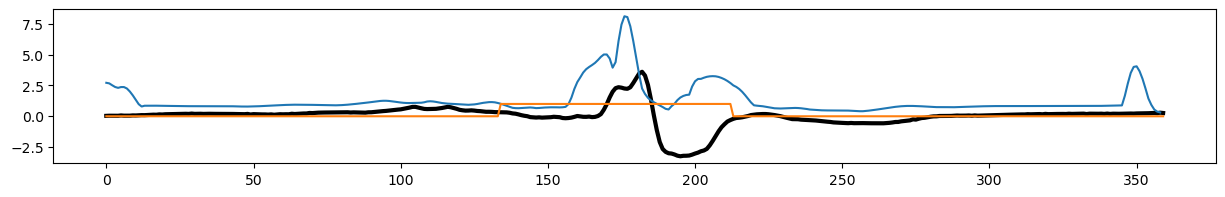

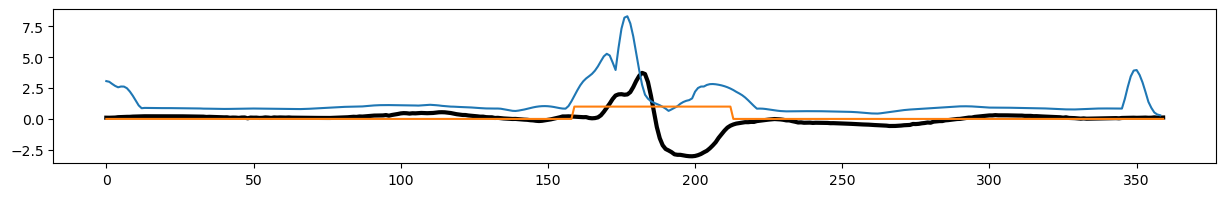

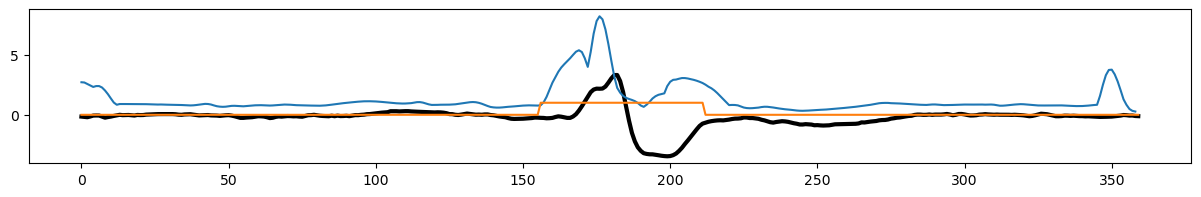

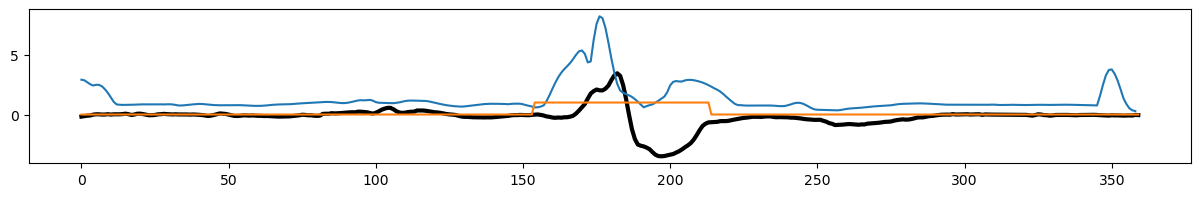

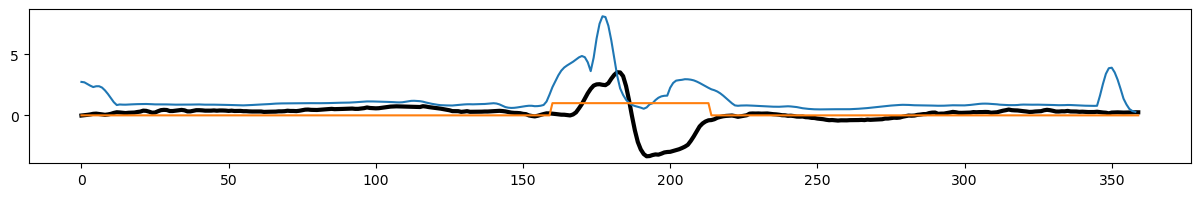

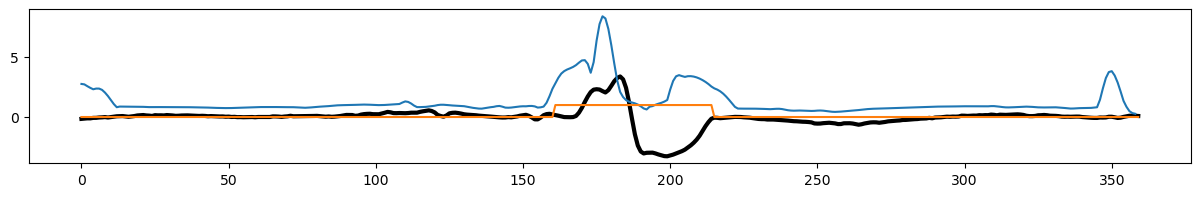

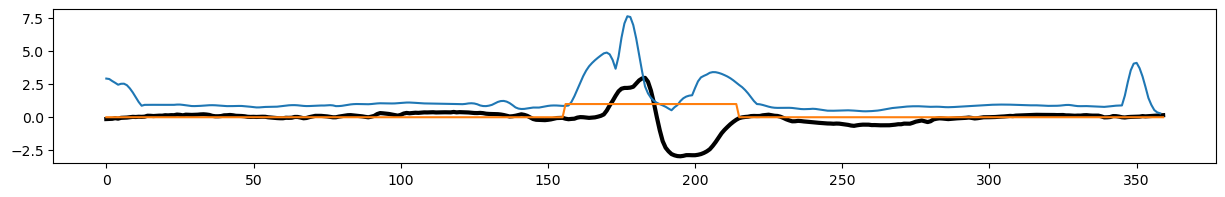

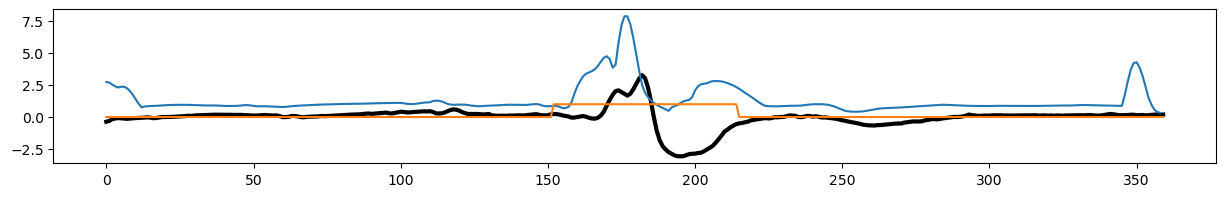

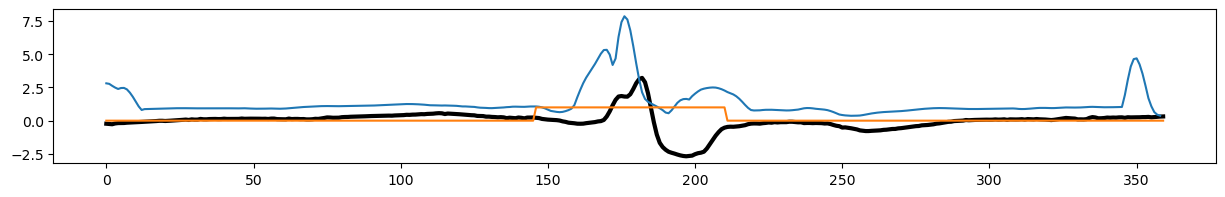

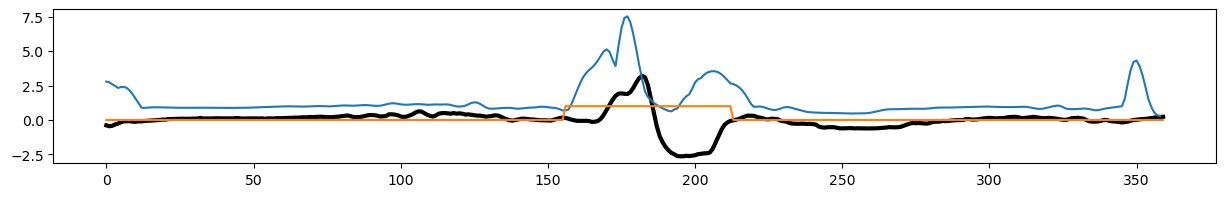

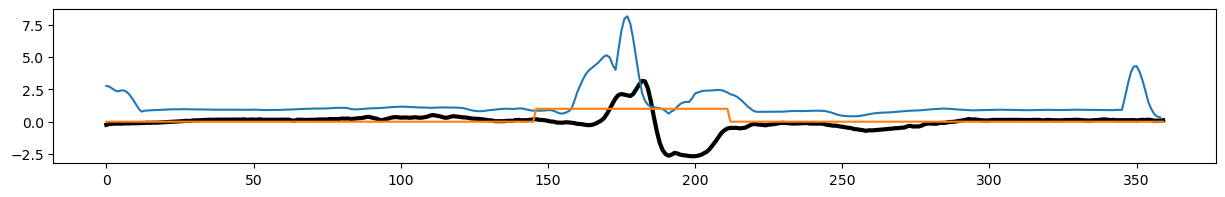

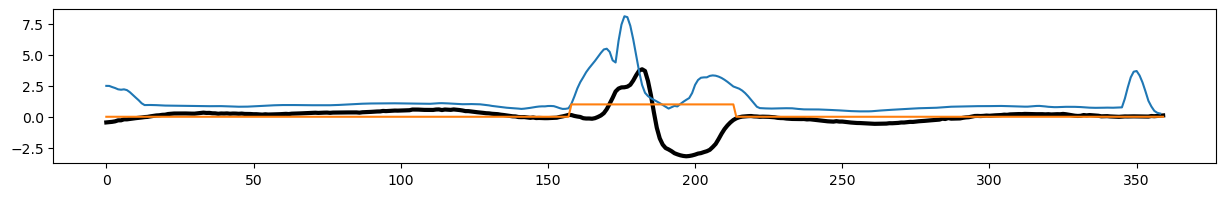

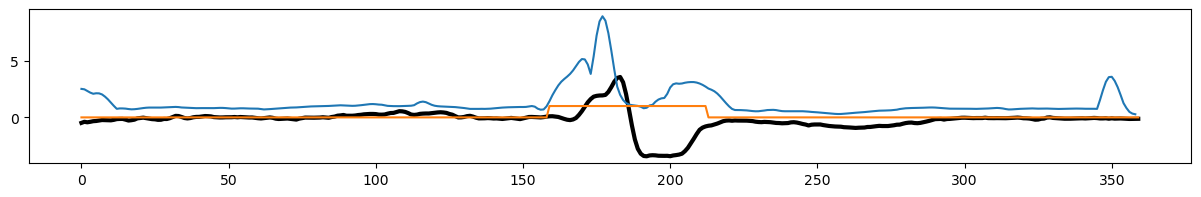

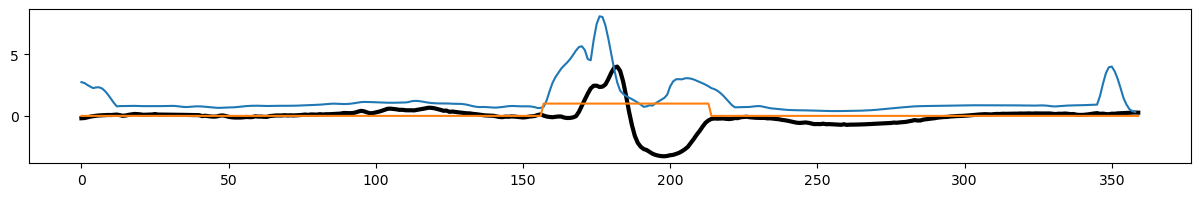

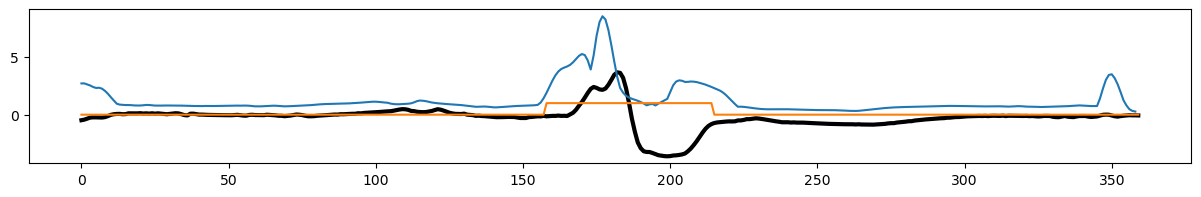

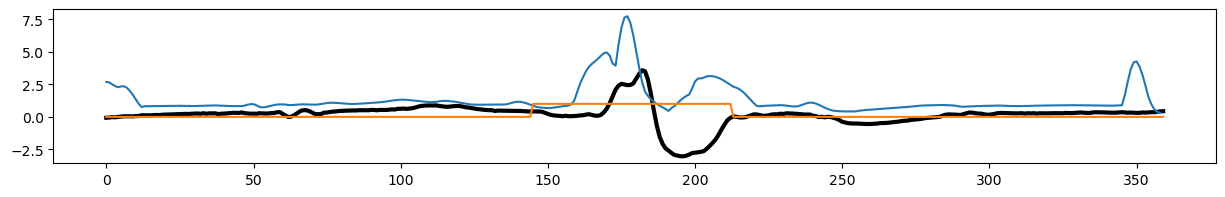

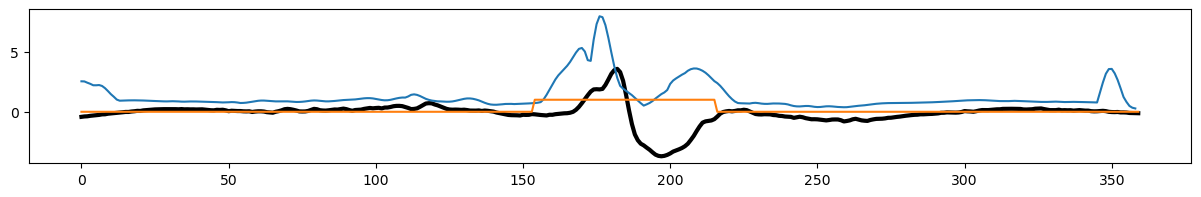

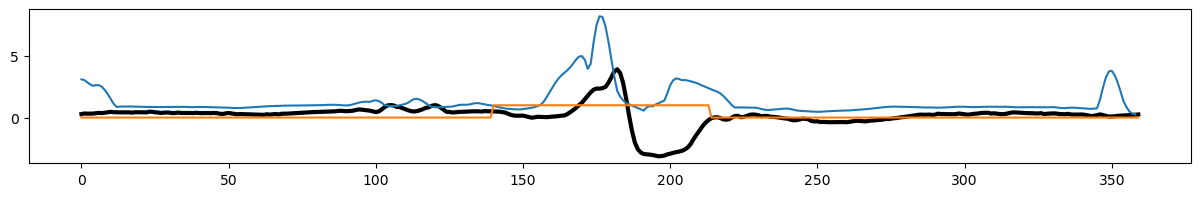

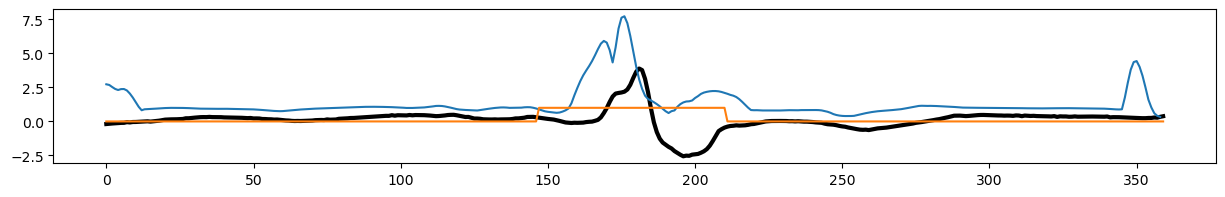

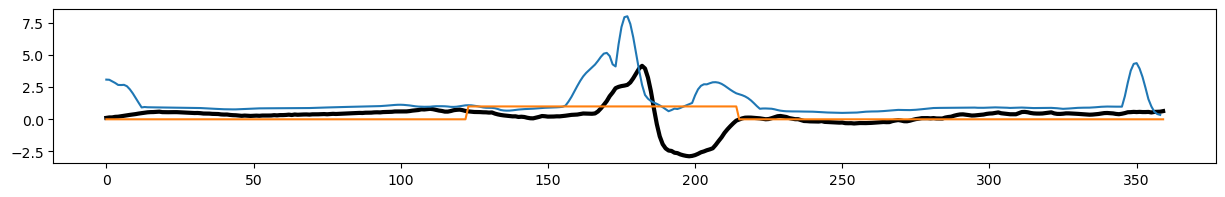

In [ ]:
# 计算第 500 个元素在哪个批次和批次中的位置
target_index = 1100  # 第  个元素对应索引  ！！2245
batch_size = 20
batch_index = target_index // batch_size  # 所在批次的索引
element_index = target_index % batch_size  # 批次内的索引

# 遍历批次直到找到包含第 500 个元素的批次
for i, batch in enumerate(dataloader):
    if i == batch_index:
        element_500 = batch
        #print(element_500)
        break
    
batch=element_500

out,actions,prototype =model(batch[0],0,0,0)
choice=0
x_show=batch[0][choice].reshape(-1).cpu()



%matplotlib inline
#print(place_holder.shape)
for choice in range(20):
    plt.figure(figsize=(15, 2))
    x_show=batch[0][choice].reshape(-1).cpu()

    plt.plot(x_show, color='black',label="Input TS",linewidth=3)
    #plt.plot([1]*SEQ_LEN, color='r',label="Input TS",linewidth=1)
    #plt.title(f" Dataset: {dataset_name}: class{batch[1][choice]},  Prototype_num: {PROTO_NUM},  Prototype_len: {proto_len}",fontsize=20)
    line=actions[choice,:,0].reshape(-1).cpu().detach().numpy()
    for i in range(1,PROTO_NUM):
        line=line+actions[choice,:,i].reshape(-1).cpu().detach().numpy()
        

        import matplotlib.pyplot as plt
        # 设置画布大小为 10 x 5 英寸


    #line=fill_short_negative_sequences(line, threshold=7)
    #line=moving_average_right(line,20)
    plt.plot(line,label=f"Activations_{i}")
    index= target_index+choice
    
    input_gt=gt_exps[:,index,:].reshape(-1).cpu().numpy()
    #input_ts=test[0][:,index,:].reshape(-1).cpu().numpy()
    plt.plot(input_gt,label=f"Activations_{i}")

    #plt.legend()

    plt.show()

In [ ]:
print(line.shape)

(359,)


In [ ]:
print(prototype.shape)

torch.Size([20, 28, 1])


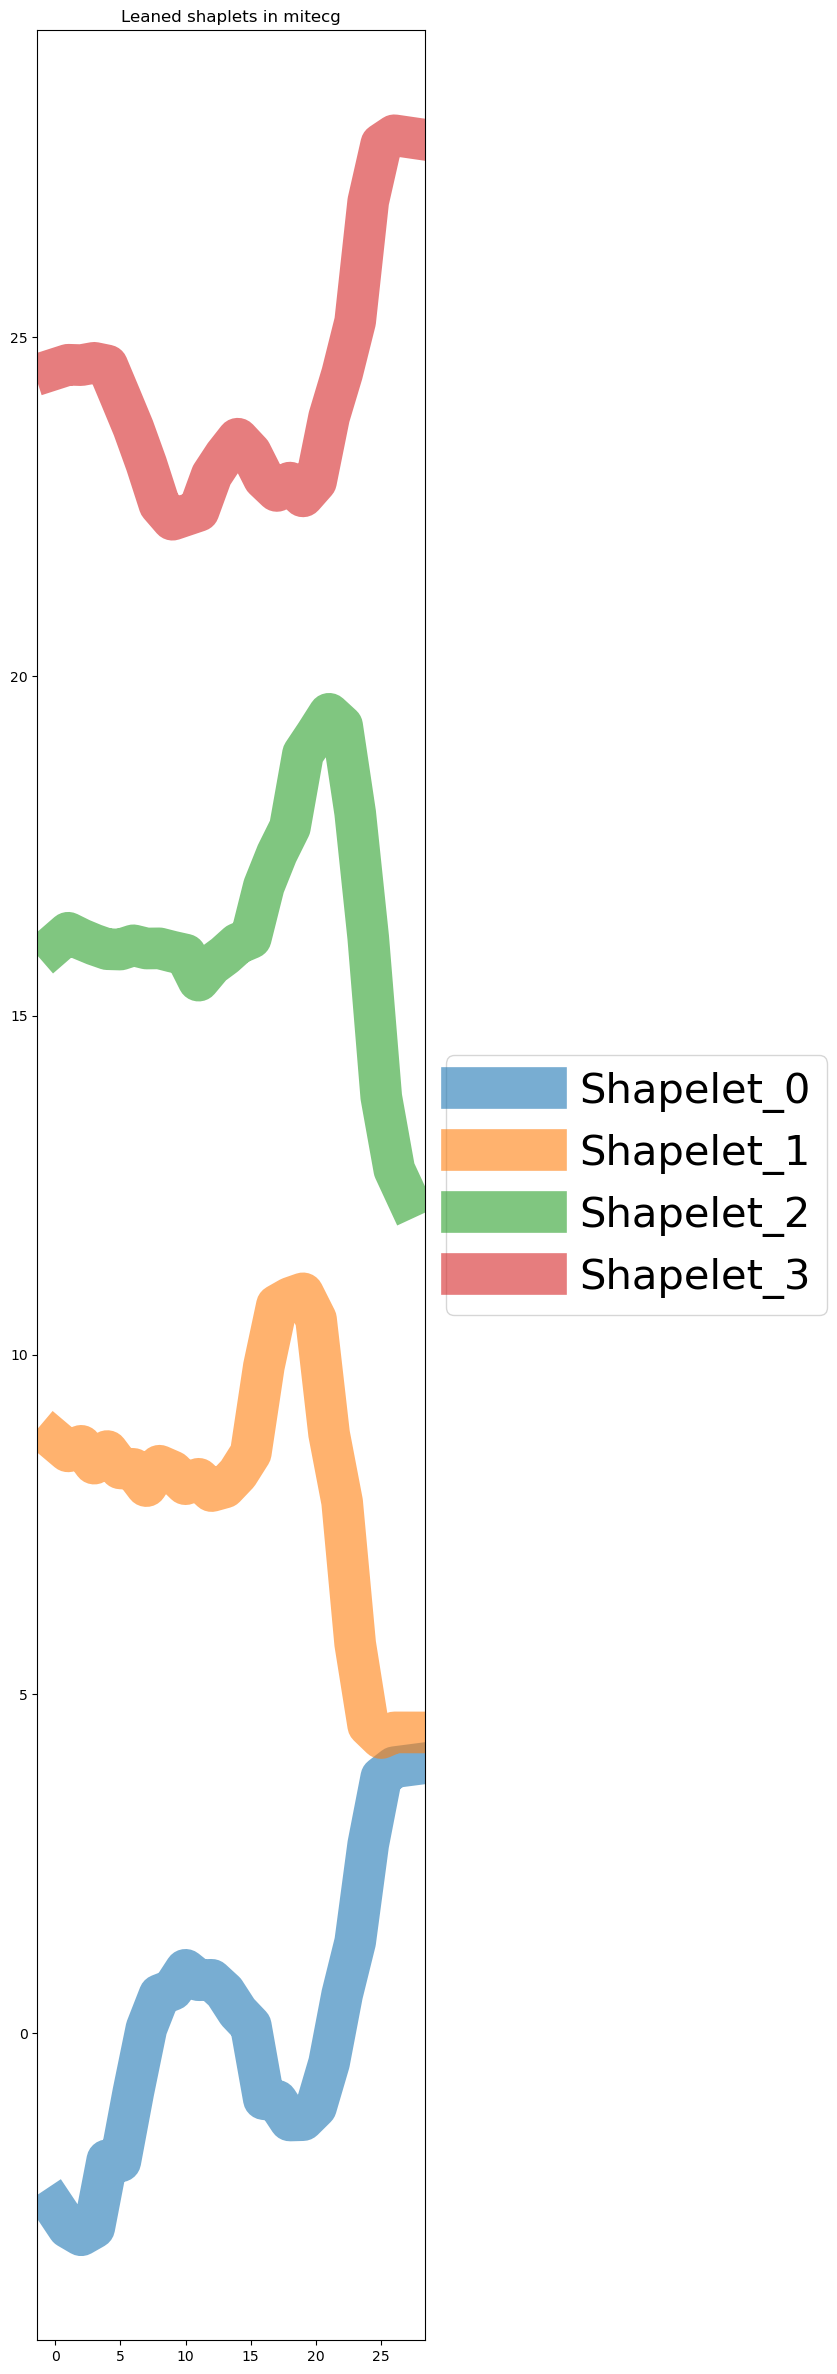

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
# 设置画布大小为 10 x 5 英寸
plt.figure(figsize=(5, 5*6))
# set backgroud to be opaque:



#x_0=[0]*proto_len
#plt.plot(x_0, color='r')
for i in range(PROTO_NUM):
    line=prototype[i,:,:].reshape(-1).cpu().detach().numpy()
    line=line+8*i
    plt.plot(line,label=f"Shapelet_{i}",linewidth=30,alpha=0.6)
    #line=prototype.reshape(-1).cpu().detach().numpy()

# set legend out of the plot,and set the size of the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=30)


    #plt.plot(line, color='g',linewidth=3)

plt.title(f"Leaned shaplets in {dataset_name}") # , without class loss

plt.savefig("output.png", transparent=True, bbox_inches='tight')

plt.show()

In [ ]:
print(gt_exps.shape)

torch.Size([50, 1000, 1])


In [ ]:
print(test[0].shape)
input_ts=test[0][:,choice,:].reshape(-1).cpu().numpy()
input_gt=gt_exps[:,choice,:].reshape(-1).cpu().numpy()

torch.Size([50, 1000, 1])


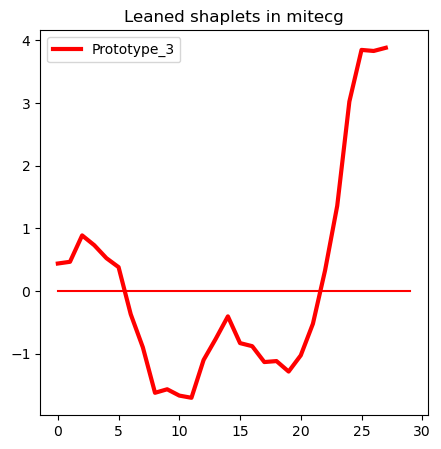

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
# 设置画布大小为 10 x 5 英寸
plt.figure(figsize=(5, 5))


x_0=[0]*proto_len
plt.plot(x_0, color='r')
#for i in range(1):
i=3
line=prototype[i,:,:].reshape(-1).cpu().detach().numpy()
plt.plot(line,label=f"Prototype_{i}",linewidth=3,color='red')
#line=prototype.reshape(-1).cpu().detach().numpy()


plt.legend()

#plt.plot(line, color='g',linewidth=3)

plt.title(f"Leaned shaplets in {dataset_name}") # , without class loss
plt.savefig("transparent_plot.png", transparent=True)
plt.show()


In [ ]:
print(prototype.shape)

torch.Size([3, 23, 1])


In [ ]:
def total_variance_loss(prototype_vectors):
    """
        prototype_vectors: [num_prototypes, patch_num, 1]
        """
    prototype_vectors=prototype_vectors.reshape(prototype_vectors.shape[0],-1)
    print("prototype_vectors.shape",prototype_vectors.shape)
    mean_embedding = torch.mean(prototype_vectors, dim=0, keepdim=True)
    deviations = prototype_vectors - mean_embedding
    variance = torch.mean(torch.sum(deviations ** 2, dim=1))
    # 最大化方差（最小化负的方差）
    loss = -variance
    print("variance",variance)
    return loss

loss=total_variance_loss(prototype)

prototype_vectors.shape torch.Size([3, 28])
variance tensor(0.1387, device='cuda:2', grad_fn=<MeanBackward0>)


In [ ]:
print(loss)

tensor(-15.0408, device='cuda:2', grad_fn=<NegBackward0>)


torch.Size([360, 1])


In [ ]:
# get seg by PropTST

# input: tensor : [seq_len,dim]

def segment_sequence(a):
    segments = []
    start = None
    current_value = None

    for i in range(len(a)):
        if a[i] != current_value:  # 当值发生变化时
            if start is not None:
                segments.append((start, i - 1))  # 记录结束索引
            start = i  # 记录新的起始索引
            current_value = a[i]  # 更新当前值

    # 处理序列结尾仍然是相同值的情况
    if start is not None:
        segments.append((start, len(a) - 1))

    return segments

def get_seg_ProtopTST(signal , ProtopTST= model,
                      
    
                      return_attention=True, ):
    """
    signal: [seq_len,dim]
    
    """
    threshold = 0.1
    
    x_in=signal.reshape(1,-1,1)
    
    out,actions,prototype =ProtopTST(x_in,0,0,0)
    
    actions_sum = torch.sum(actions,dim=-1).reshape(-1)
    
    actions_sum = (actions_sum  > threshold).int()
    
    segs=segment_sequence(actions_sum)
    
    return segs,actions_sum



    
    
    
    
    
    

In [ ]:
signal=batch[0][choice]
print(signal.shape)
segs,actions_sum = get_seg_ProtopTST(signal,model)

%matplotlib inline

import matplotlib.pyplot as plt
# 设置画布大小为 10 x 5 英寸
plt.figure(figsize=(5, 5))

plt.plot(signal.reshape(-1).cpu().detach().numpy(), color='b')

plt.plot(actions_sum.cpu().detach().numpy(), color='r')

#line=prototype.reshape(-1).cpu().detach().numpy()


plt.legend()

#plt.plot(line, color='g',linewidth=3)

plt.title(f"Leaned shaplets in {dataset_name}") # , without class loss

plt.show()

torch.Size([360, 1])


NameError: name 'get_seg_ProtopTST' is not defined